# Import

In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Data

In [39]:
path = "dataset/train.csv"
df_train = pd.read_csv(path)

path = "dataset/test.csv"
df_test = pd.read_csv(path)

In [40]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 co

In [41]:
print(df_train)
print(df_test)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pd

In [42]:
# Check Duplication row in training data
print(df_train.duplicated().sum())

0


In [43]:
# All of the rows inside df_test seems to be also inside the df_train
duplicates = pd.merge(df_train, df_test, how='inner')
duplicates

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
1,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no
2,57,services,married,secondary,no,162,yes,no,unknown,5,may,174,1,-1,0,unknown,no
3,57,technician,married,secondary,no,839,no,yes,unknown,5,may,225,1,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,35,technician,married,secondary,no,0,yes,no,cellular,9,nov,524,1,96,5,success,yes
4517,36,admin.,single,tertiary,no,980,no,no,cellular,11,nov,118,4,104,7,failure,no
4518,75,retired,divorced,tertiary,no,3810,yes,no,cellular,16,nov,262,1,183,1,failure,yes
4519,36,management,single,secondary,no,1511,yes,no,cellular,16,nov,270,1,-1,0,unknown,yes


In [44]:
# Unique values in each column
for col in df_train:
    print(f'+ Unique values in {col}: {df_train[col].unique()}')

+ Unique values in age: [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
+ Unique values in job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
+ Unique values in marital: ['married' 'single' 'divorced']
+ Unique values in education: ['tertiary' 'secondary' 'unknown' 'primary']
+ Unique values in default: ['no' 'yes']
+ Unique values in balance: [ 2143    29     2 ...  8205 14204 16353]
+ Unique values in housing: ['yes' 'no']
+ Unique values in loan: ['no' 'yes']
+ Unique values in contact: ['unknown' 'cellular' 'telephone']
+ Unique values in day: [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
+ Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' '

In [45]:
# Number of unique values
df_train.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [46]:
# Merge train and test dataset and Drop Duplicate row 
merge_train_test = pd.concat([df_train, df_test])
new_df = merge_train_test.drop_duplicates()
# new_df

In [47]:
# Number of yes and no in the response feature, only around 12% yes out of all
counts = new_df['y'].value_counts()
counts

y
no     39922
yes     5289
Name: count, dtype: int64

# Split Data

In [48]:
X = new_df.iloc[:,:16]
y = new_df.iloc[:,16]

X_train, X_temp, y_train, y_temp = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_temp,y_temp, random_state=42, test_size=0.5, stratify=y_temp)

# Data Preprocessing

In [49]:
numeric_features = ['age','balance','day','duration','campaign','pdays','previous']

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_features = ['job','marital','education','default','housing',
                        'loan','contact','month','poutcome']

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Fit and transform the training data and transform the val and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [50]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Percentages of yes in each of train, val, test dataset
print(sum(y_train)/len(y_train))
print(sum(y_val)/len(y_val))
print(sum(y_test)/len(y_test))

label_names = label_encoder.classes_
label_names

0.11698186241981863
0.11698363555948696
0.11700951117009512


array(['no', 'yes'], dtype=object)

# Models Assessment with default hyperparameters:

In [51]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## DecisionTree

In [52]:
decisiontreeclf = DecisionTreeClassifier()
# print(decisiontreeclf.get_params())

print(cross_val_score(decisiontreeclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.4846140175635726


## RandomForest

In [53]:
randomforestclf = RandomForestClassifier()
# print(randomforestclf.get_params())

print(cross_val_score(randomforestclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.4890709520954391


## AdaBoost

In [54]:
adaclf = AdaBoostClassifier(algorithm="SAMME")
# print(adaclf.get_params())

print(cross_val_score(adaclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.4270184107361099


## GradientBoosting

In [55]:
gbclf = GradientBoostingClassifier()
# print(gbclf.get_params())

print(cross_val_score(gbclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.5089385103541033


## XGBoost

In [56]:
xgbclf = xgb.XGBClassifier()
# print(xgbclf.get_params())

print(cross_val_score(xgbclf, X_train_transformed, y_train, cv=kfold, scoring='f1').mean())

0.5567000077176639


# Preliminary XGBoost Model:

In [57]:
xgbclf1 = xgb.XGBClassifier(
    objective="binary:logistic",
    seed=42,
    eval_metric="aucpr",
    n_estimators=200,
    early_stopping_rounds=10,
    tree_method='exact',
    booster='gbtree',
)

model1 = xgbclf1.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)],
    verbose=True,
)

[0]	validation_0-aucpr:0.56060	validation_1-aucpr:0.53469
[1]	validation_0-aucpr:0.59625	validation_1-aucpr:0.54518
[2]	validation_0-aucpr:0.61789	validation_1-aucpr:0.56162
[3]	validation_0-aucpr:0.63357	validation_1-aucpr:0.56959
[4]	validation_0-aucpr:0.64069	validation_1-aucpr:0.56812
[5]	validation_0-aucpr:0.65551	validation_1-aucpr:0.57236
[6]	validation_0-aucpr:0.65972	validation_1-aucpr:0.57662
[7]	validation_0-aucpr:0.66694	validation_1-aucpr:0.58079
[8]	validation_0-aucpr:0.67399	validation_1-aucpr:0.57892
[9]	validation_0-aucpr:0.67839	validation_1-aucpr:0.57867
[10]	validation_0-aucpr:0.68692	validation_1-aucpr:0.58347
[11]	validation_0-aucpr:0.69097	validation_1-aucpr:0.58902
[12]	validation_0-aucpr:0.69527	validation_1-aucpr:0.59121
[13]	validation_0-aucpr:0.70142	validation_1-aucpr:0.59527
[14]	validation_0-aucpr:0.71210	validation_1-aucpr:0.59929
[15]	validation_0-aucpr:0.71592	validation_1-aucpr:0.60144
[16]	validation_0-aucpr:0.72177	validation_1-aucpr:0.60219
[17]	va

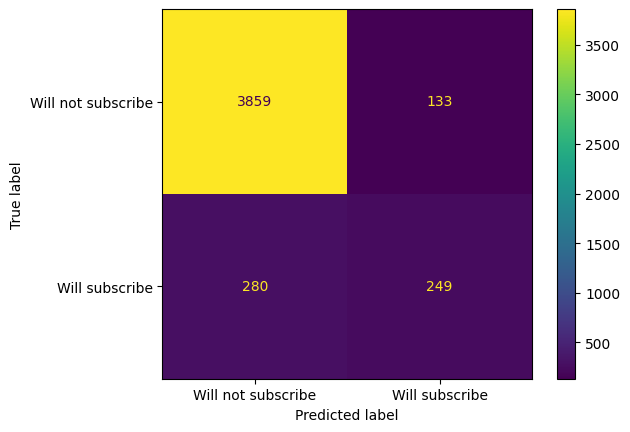

In [58]:
predictions = model1.predict(X_test_transformed)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Will not subscribe', 'Will subscribe'])
disp.plot()

# Hyperparameters tuning

In [59]:
# Round One
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1],
#     'reg_lambda': [0, 1, 10],
#     'scale_pos_weight': [1, 3, 5],
# }

# Round Twos
# param_grid = {
#     'max_depth': [5,7,9],
#     'learning_rate': [0.1, 0.3, 0.5],
#     'gamma': [0.25],
#     'reg_lambda': [0, 0.25, 0.5],
#     'scale_pos_weight': [3],
# }

# grid_search = GridSearchCV(
#     estimator=xgb.XGBClassifier(
#                                 objective='binary:logistic',
#                                 seed=42,
#                                 # subsample=0.9,
#                                 # colsample_bytree=0.5,
#                                 early_stopping_rounds=10,
#                                 eval_metric='auc',
#                                ),
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=kfold,  
#     verbose=0
# )

# grid_search.fit(X_train_transformed,
#                 y_train,
#                 eval_set=[(X_val_transformed, y_val)],
#                 verbose=False
#                )

# print("Best hyperparameters: ", grid_search.best_params_)

In [60]:
# with subsample and colsample_bytree
# {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}
# {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0.25, 'scale_pos_weight': 3}

# without subsample and colsample_bytree
# {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}
# {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.25, 'scale_pos_weight': 3}

In [61]:
xgbclf2 = xgb.XGBClassifier(
    objective='binary:logistic',
    seed=42,
    eval_metric='aucpr',
    n_estimators=200,
    early_stopping_rounds=10,
    tree_method='exact',
    booster='gbtree',
    gamma=0.25,
    learning_rate=0.1,
    max_depth=7,
    reg_lambda=0.25,
    scale_pos_weight=3,
)

model2 = xgbclf2.fit(X_train_transformed,
          y_train,
          eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)],
          verbose=True        
)

[0]	validation_0-aucpr:0.59447	validation_1-aucpr:0.54044
[1]	validation_0-aucpr:0.62396	validation_1-aucpr:0.57054
[2]	validation_0-aucpr:0.63509	validation_1-aucpr:0.57129
[3]	validation_0-aucpr:0.64262	validation_1-aucpr:0.58001
[4]	validation_0-aucpr:0.64765	validation_1-aucpr:0.58127
[5]	validation_0-aucpr:0.65234	validation_1-aucpr:0.58136
[6]	validation_0-aucpr:0.65937	validation_1-aucpr:0.58996
[7]	validation_0-aucpr:0.66371	validation_1-aucpr:0.59008
[8]	validation_0-aucpr:0.66643	validation_1-aucpr:0.59037
[9]	validation_0-aucpr:0.66843	validation_1-aucpr:0.59095
[10]	validation_0-aucpr:0.67133	validation_1-aucpr:0.59144
[11]	validation_0-aucpr:0.67415	validation_1-aucpr:0.59503
[12]	validation_0-aucpr:0.67837	validation_1-aucpr:0.59839
[13]	validation_0-aucpr:0.68140	validation_1-aucpr:0.60096
[14]	validation_0-aucpr:0.68593	validation_1-aucpr:0.60250
[15]	validation_0-aucpr:0.68947	validation_1-aucpr:0.60409
[16]	validation_0-aucpr:0.69404	validation_1-aucpr:0.60246
[17]	va

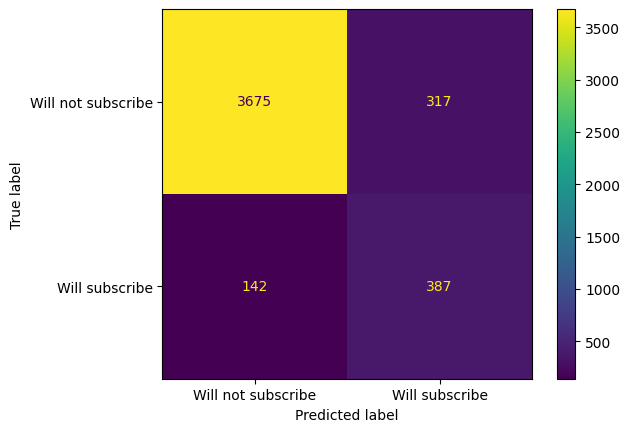

In [62]:
predictions = model2.predict(X_test_transformed)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Will not subscribe', 'Will subscribe'])
disp.plot()

## Feature Importance

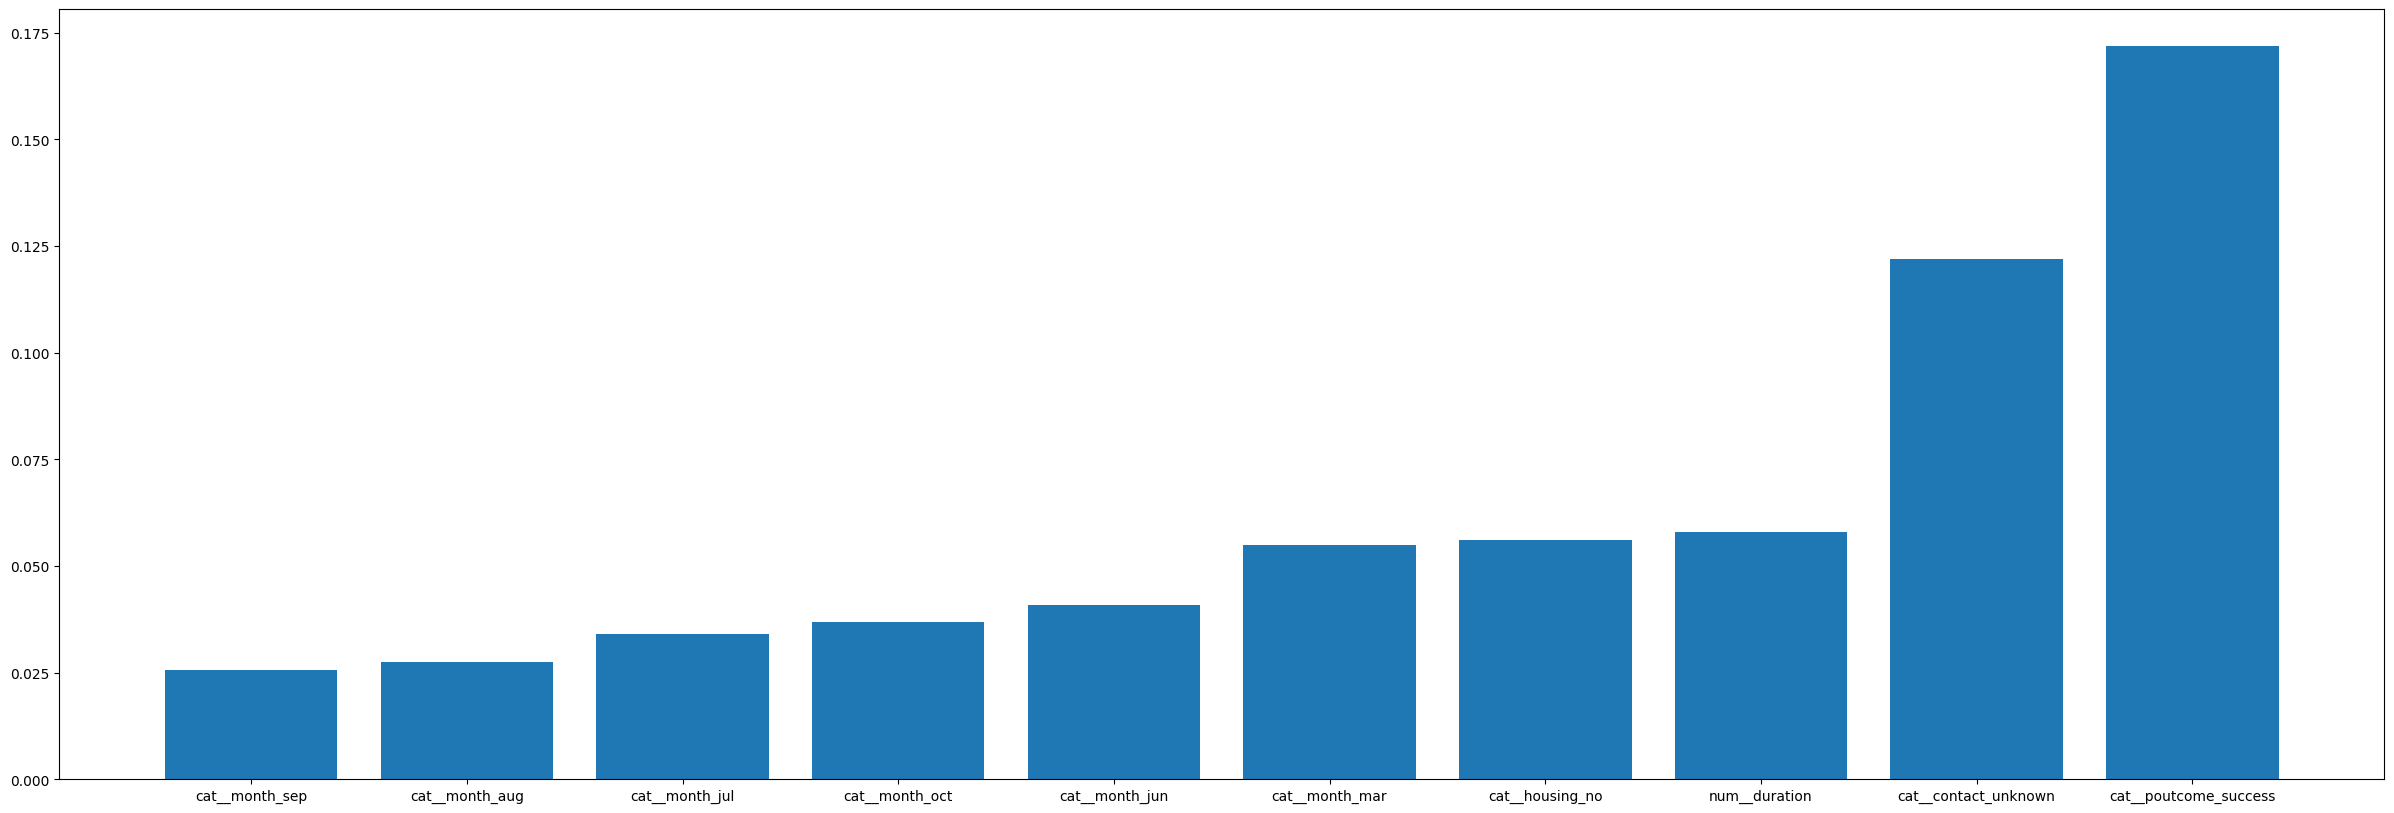

In [63]:
# All Feature names 
feature_names  = preprocessor.get_feature_names_out().tolist()

# Importance score for each feature
importance_score = model2.feature_importances_
# model2.get_booster().get_score(importance_type= 'gain')

# Zip and sort
res = dict(zip(feature_names, importance_score))
sorted_by_values = sorted(res.items(), key=lambda x:x[1])

# Top 10 features
n = 10
top_n_features = sorted_by_values[-n:]
data = dict(top_n_features)
names = list(data.keys())
values = list(data.values())
fig, ax = plt.subplots(figsize=(30, 10))
plt.bar(range(len(data)), values, tick_label=names)
plt.show()

In [64]:
contingency_table = pd.crosstab(new_df.poutcome, new_df.y, margins= False)
contingency_table

y,no,yes
poutcome,,
failure,4283,618
other,1533,307
success,533,978
unknown,33573,3386


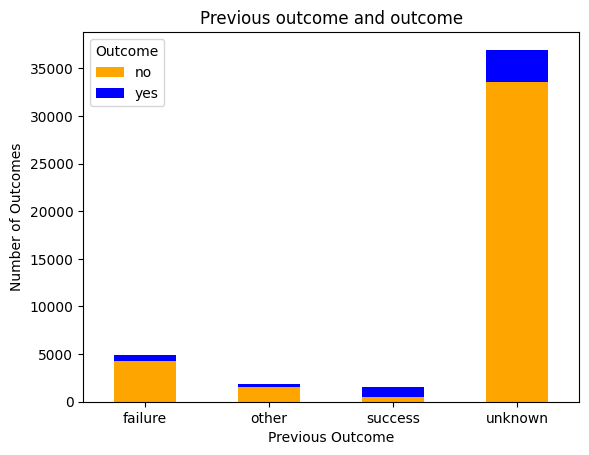

In [65]:
contingency_table.plot(kind='bar', color={'yes': 'blue', 'no': 'orange'}, stacked=True ,rot=0, 
                xlabel='Previous Outcome', ylabel='Number of Outcomes', title='Previous outcome and outcome')
plt.legend(title='Outcome')
plt.show()

# Final Evaluation

In [66]:
y_pred = xgbclf1.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9086485290864853
Precision: 0.6518324607329843
Recall: 0.4706994328922495
F1 Score: 0.5466520307354555


In [67]:
y_pred = xgbclf2.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8984737889847378
Precision: 0.5497159090909091
Recall: 0.7315689981096408
F1 Score: 0.6277372262773723


# Serialization 

In [68]:
# xgbclfout = Pipeline(
#     steps=[
#         ('preprocessor', preprocessor),
#         ('model', model2)
#     ]
# )

# joblib.dump(xgbclfout, "my_model.pkl")